# Face Generation using a DCGAN

In this project, I'll define and train a DCGAN (Deep Covolutional Generative Adversarial Network) on a dataset of faces. My goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project is broken down into sections, starting from **loading in data to defining and training adversarial networks**. At the end of the notebook, I'll visualize the results of my trained Generator to see how it performs; my generated samples should look like fairly realistic faces with small amounts of noise.

### Getting the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train my adversarial networks.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is shown below.

<img src='assets/processed_face_data.png' width=60% />

In [1]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Visualizing the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since I'm going to be generating faces, I won't need the annotations, I'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-processing and Loading the Data
I will have to do some additional preprocessing to the images in order to maximize the efficiency of the training process and the accuracy of the model.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor()])
        
    dataset = datasets.ImageFolder(data_dir, transform = transform)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

## Creating a DataLoader

Below, I'll call the above function and create a dataloader to view images. 

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32

# Call the function to get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, I will view some images.

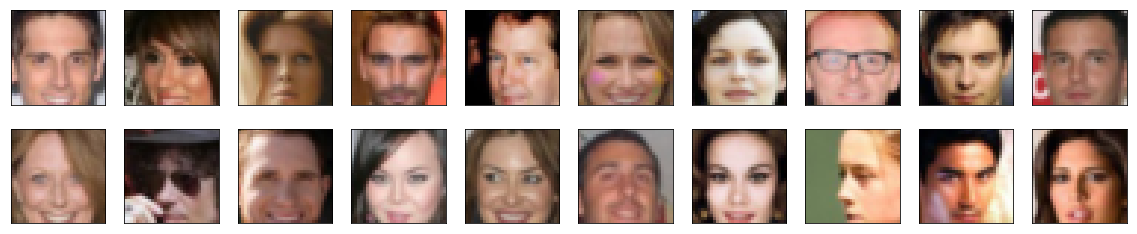

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

I know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, I need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_data, max_data = feature_range
    x = x*(max_data-min_data) + min_data
    return x

In [7]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

# test
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8745)
Max:  tensor(0.9451)


---
# Defining the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

First, I'll define the discriminator. This is a convolutional classifier, only without any maxpooling layers, and it works as follows:

* The inputs to the discriminator are 32x32x3 tensor images
* The output will be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # use Sequential container
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        ## init function
        self.conv_dim = conv_dim
        
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        ## feedforward behavior
        
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.conv2(x),0.2)
        x = F.leaky_relu(self.conv3(x),0.2)
        
        # flatten
        x = x.view(-1,self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)        
        return x

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. 

The generator works as follows:
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_transpose=nn.ConvTranspose2d(in_channels,out_channels,
                                      kernel_size,stride,padding,bias=False)
    
    # append deconv layer
    layers.append(conv_transpose)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # use Sequential container
    return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        ## init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size,conv_dim*4*4*4,5)
        
        # transpose conv layers
        self.deconv1 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv2 = deconv(conv_dim*2,conv_dim,4)
        self.deconv3 = deconv(conv_dim,3,4,batch_norm=False)        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        ## feedforward behavior
        
        # fully-connected + reshape
        x = self.fc(x)
        x = x.view(-1,self.conv_dim*4,4,4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        # last layer + tanh activation
        x = F.tanh(self.deconv3(x))        
        return x

## Initializing the weights of the networks

From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, I will define a weight initialization function that does just this.

The function will:
* Initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    # appply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
        
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(0)

## Building the complete network

In [13]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Defining model hyperparameters and creating the models

In [14]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 256
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=16384, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(

### Training on GPU

First, I'll check if there's a GPU, then later I have to make sure that:  
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Training on CPU')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now I need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* I want the discriminator to output 1 for real images and 0 for fake images, so I need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

Next, I will define `real_loss` and `fake_loss` functions.

In [16]:
def real_loss(D_out):
    batch_size = D_out.size(0)

    labels = torch.ones(batch_size)
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Next, I'll define optimizers for my models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002,betas=(0.5, .99))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002,betas=(0.5, .99))

---
## Training

Training will involve alternating between training the discriminator and the generator. I'll use the functions `real_loss` and `fake_loss` to help calculate the discriminator losses.

* I will train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

In [18]:
def train(D, G, n_epochs, print_every=500):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ====================
            #  TRAIN THE NETWORKS
            # ====================
            
            # 1. Train the discriminator on real and fake images
            # training on real images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            d_real_loss = real_loss(D(real_images))
            
            # train on fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            d_fake_loss = fake_loss(D(fake_images))
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            fake_images=G(z)
            
            g_loss =real_loss(D(fake_images)) 
            
            g_loss.backward()
            
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Next I will set the number of training epochs and then start training the DCGA

In [19]:
# set number of epochs 
n_epochs = 15

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   15] | d_loss: 1.5773 | g_loss: 1.0410
Epoch [    1/   15] | d_loss: 1.2475 | g_loss: 1.1016
Epoch [    1/   15] | d_loss: 1.2196 | g_loss: 1.0908
Epoch [    2/   15] | d_loss: 1.3837 | g_loss: 1.6301
Epoch [    2/   15] | d_loss: 1.2931 | g_loss: 1.6922
Epoch [    2/   15] | d_loss: 1.4656 | g_loss: 1.7429
Epoch [    3/   15] | d_loss: 1.3879 | g_loss: 2.0556
Epoch [    3/   15] | d_loss: 1.3479 | g_loss: 0.5878
Epoch [    3/   15] | d_loss: 1.1670 | g_loss: 0.6951
Epoch [    4/   15] | d_loss: 1.1515 | g_loss: 2.4260
Epoch [    4/   15] | d_loss: 1.1239 | g_loss: 1.4222
Epoch [    4/   15] | d_loss: 1.0652 | g_loss: 1.1698
Epoch [    5/   15] | d_loss: 0.9591 | g_loss: 0.8192
Epoch [    5/   15] | d_loss: 1.0845 | g_loss: 1.0430
Epoch [    5/   15] | d_loss: 1.3353 | g_loss: 1.4326
Epoch [    6/   15] | d_loss: 1.3202 | g_loss: 2.3976
Epoch [    6/   15] | d_loss: 1.2337 | g_loss: 2.0413
Epoch [    6/   15] | d_loss: 1.3880 | g_loss: 2.4644
Epoch [    7/   15] | d_loss

## Training loss

Here, I will plot the training losses for the generator and discriminator, recorded after each epoch.

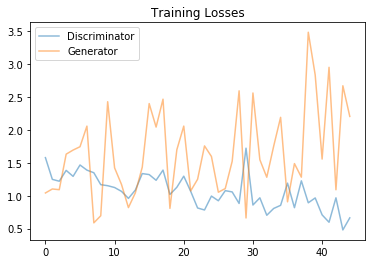

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Next, I'll view samples of images from the generator.

In [21]:
# function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

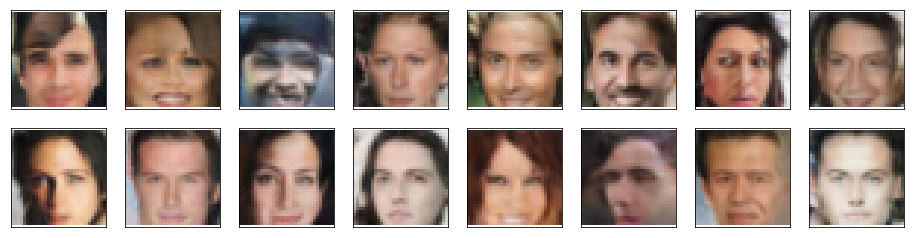

In [23]:
_ = view_samples(-1, samples)

The accuracy of the model is good overall, but I think it can get more accurate if I deepen the structure of the neural networks. Generally speaking,  the model also should train on more face images. 